In [3]:
#Import modules
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import patches, text, patheffects
import cv2
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [4]:
def group_DBSCAN(df):
    x = df[["c_x", "c_y"]].to_numpy()
    cluster = DBSCAN(eps=15, min_samples=5).fit(x)
    labels = cluster.labels_
    df["cluster_id"] = labels
    return labels
    #n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    #n_noise_ = list(labels).count(-1)
    
    #EVENTUALLY: run DBSCAN, or sort for running H-Cluster if DBSCAN gives a bad result
    #hcluster = []
    #comp = int(len(df)) / len(((df["labeler_id"].unique())))
    #decision = comp / int(n_clusters_)
    #if decision > 0.9:
    #    df["cluster_id"] = labels
    #    return labels
    #else:
    #    hcluster.append(df["filename"])
    #    return hcluster

In [ ]:
#Needs more work later-- will require different method to define labels
def group_Hcluster(df):
    data = df["centers"]
    thresh = 14
    hclusters = hcluster.fclusterdata(data, thresh, criterion="distance")


In [5]:
#JSON file with all image labels
labelpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Labels/coco/20220227_dgc.json"
with open(labelpath) as f:
  #df = pd.read_json(f)
  cocozoo = pd.read_json(f) #delete this and use above instead once ready to run with all images

#Directory of images-- remember to change this to the full directory when the script is ready
imgpath = r"/Users/rowanconverse/Library/CloudStorage/OneDrive-UniversityofNewMexico/CV4Ecology/Prototyping/Data/Imagery/SB597/scratch/test"
imglist = os.listdir(imgpath)

In [6]:
#Creating a multi-image subset to work with (delete this for full version)
df = cocozoo[cocozoo["filename"].isin(imglist)]

In [7]:
#CREATE NEW COLUMNS FOR INPUT INTO DBSCAN

#Derive bounding box centers
bboxes = df["bbox"]
c_x = []
c_y = []
x = []
y = []
w = []
h = []
centers = []
for coord in bboxes:
    center = (coord[0]+(coord[2]/2), coord[1]+(coord[3]/2))
    c_x.append(center[0])
    c_y.append(center[1])
    x.append(coord[0])
    y.append(coord[1])
    w.append(coord[2])
    h.append(coord[3])
    centers.append(center)
#Make these centers into a coordinate format
coords = []
for row in centers:
    coord = list(row)
    coords.append(coord)
#Append new columns to dataframe for manipulating later
df["c_x"] = c_x
df["c_y"] = c_y
df['x'] = x
df['y'] = y
df['w'] = w
df['h'] = h

/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_8026/3272824413.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c_x"] = c_x
/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_8026/3272824413.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c_y"] = c_y
/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_8026/3272824413.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [8]:
#df['cluster_id'] = pd.Series()
df.head()

,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id,c_x,c_y,x,y,w,h
15013,15014,"[314.8125, 131, 91, 43]",3913.0,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,360.3125,152.5,314.8125,131.0,91.0,43.0
15014,15015,"[266.8125, 7, 55, 59]",3245.0,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,294.3125,36.5,266.8125,7.0,55.0,59.0
15015,15016,"[145.8125, 17, 62, 60]",3720.0,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,176.8125,47.0,145.8125,17.0,62.0,60.0
15016,15017,"[-18.1875, 15, 78, 38]",2964.0,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,20.8125,34.0,-18.1875,15.0,78.0,38.0
15017,15018,"[213.8125, 28, 54, 60]",3240.0,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,240.8125,58.0,213.8125,28.0,54.0,60.0


In [9]:
clusters = df.groupby("filename").apply(lambda x: group_DBSCAN(x))
clusters = clusters.reset_index()
#clusters = clusters.rename({0:"cluster_id"})


In [10]:
clusters.rename(columns = {0:'cluster_id'}, inplace=True)
clusters.head()

,filename,cluster_id
0,20211201_Atrisco_0465_07_01.png,"[0, 1, 2, 3, 4, 4, 3, 2, 0, 1, 0, 1, -1, 4, 3,..."
1,20220110_Bernardo_0001_01_03.png,"[0, 1, 2, 3, -1, 4, 5, 6, 7, 1, 0, 2, 6, 7, 5,..."
2,20220110_Bernardo_0230_05_08.png,"[0, -1, -1, 1, 2, 3, 4, 5, 6, 4, 2, 1, 3, 0, 7..."
3,20220110_Bernardo_0999_06_06.png,"[0, 10, 1, 2, 3, -1, 4, 5, 12, 6, 7, 8, 9, 0, ..."
4,20220111_Bernardo_0491_03_07.png,"[0, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, -1, 1, 2, 0,..."


In [11]:
filesort = df.sort_values(["filename", "annotation_id"])
filegroup = df.groupby("filename")

In [12]:
filesort.reset_index()

,index,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id,c_x,c_y,x,y,w,h
0,920783,920784,"[219.5604705810547, 62.35216522216797, 104.820...",6793.060834,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,271.970970,94.755314,219.560471,62.352165,104.820999,64.806297
1,920784,920785,"[274.8517150878906, 130.38270568847656, 119.36...",8279.833262,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,334.532043,165.066803,274.851715,130.382706,119.360657,69.368195
2,920785,920786,"[166.7265625, 197.84608459472656, 112.00064086...",8212.846555,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,222.726883,234.510368,166.726562,197.846085,112.000641,73.328568
3,920786,920787,"[128.72052001953125, 303.2448425292969, 103.28...",6923.001768,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,180.363495,336.758606,128.720520,303.244843,103.285950,67.027527
4,920787,920788,"[26.806745529174805, 382.2096862792969, 101.21...",7227.177539,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,77.415030,417.911240,26.806746,382.209686,101.216570,71.403107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,574175,574176,"[417, 146.625, 29, 41]",1189.000000,2,Goose,18220,FWS_MaxwellLake13_20171215_3_01942_06_08.png,3100,431.500000,167.125000,417.000000,146.625000,29.000000,41.000000
2155,574176,574177,"[474, 174.625, 31, 28]",868.000000,2,Goose,18220,FWS_MaxwellLake13_20171215_3_01942_06_08.png,3100,489.500000,188.625000,474.000000,174.625000,31.000000,28.000000
2156,574177,574178,"[494, 137.625, 29, 41]",1189.000000,2,Goose,18220,FWS_MaxwellLake13_20171215_3_01942_06_08.png,3100,508.500000,158.125000,494.000000,137.625000,29.000000,41.000000
2157,574178,574179,"[525, 156.625, 29, 40]",1160.000000,2,Goose,18220,FWS_MaxwellLake13_20171215_3_01942_06_08.png,3100,539.500000,176.625000,525.000000,156.625000,29.000000,40.000000


In [66]:
filegroup.head()

,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id,c_x,c_y,x,y,w,h
15013,15014,"[314.8125, 131, 91, 43]",3913.000000,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,360.312500,152.500000,314.812500,131.000000,91.000000,43.000000
15014,15015,"[266.8125, 7, 55, 59]",3245.000000,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,294.312500,36.500000,266.812500,7.000000,55.000000,59.000000
15015,15016,"[145.8125, 17, 62, 60]",3720.000000,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,176.812500,47.000000,145.812500,17.000000,62.000000,60.000000
15016,15017,"[-18.1875, 15, 78, 38]",2964.000000,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,20.812500,34.000000,-18.187500,15.000000,78.000000,38.000000
15017,15018,"[213.8125, 28, 54, 60]",3240.000000,3,Duck,2536,BDA_18a4_20181106_2_00295_01_04.png,437,240.812500,58.000000,213.812500,28.000000,54.000000,60.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975658,975659,"[494.75, 371.4666748046875, 54, 46]",2484.000000,3,Duck,28933,20220111_LaJoya_1_0024_07_07.png,4596,521.750000,394.466675,494.750000,371.466675,54.000000,46.000000
975659,975660,"[446.75, 375.4666748046875, 57, 48]",2736.000000,3,Duck,28933,20220111_LaJoya_1_0024_07_07.png,4596,475.250000,399.466675,446.750000,375.466675,57.000000,48.000000
975660,975661,"[542.75, 427.4666748046875, 43, 38]",1634.000000,3,Duck,28933,20220111_LaJoya_1_0024_07_07.png,4596,564.250000,446.466675,542.750000,427.466675,43.000000,38.000000
975661,975662,"[541.75, 479.4666748046875, 58, 38]",2204.000000,3,Duck,28933,20220111_LaJoya_1_0024_07_07.png,4596,570.750000,498.466675,541.750000,479.466675,58.000000,38.000000


In [13]:
long = clusters.explode("cluster_id")
long.reset_index()

,index,filename,cluster_id
0,0,20211201_Atrisco_0465_07_01.png,0
1,0,20211201_Atrisco_0465_07_01.png,1
2,0,20211201_Atrisco_0465_07_01.png,2
3,0,20211201_Atrisco_0465_07_01.png,3
4,0,20211201_Atrisco_0465_07_01.png,4
...,...,...,...
2154,25,FWS_MaxwellLake13_20171215_3_01942_06_08.png,8
2155,25,FWS_MaxwellLake13_20171215_3_01942_06_08.png,7
2156,25,FWS_MaxwellLake13_20171215_3_01942_06_08.png,10
2157,25,FWS_MaxwellLake13_20171215_3_01942_06_08.png,11


In [14]:
test = filesort.reset_index().merge(long.reset_index(), left_index=True, right_index=True, how='left')
test = test.drop(columns=['filename_y','index_y'])
test = test.rename(columns={'filename_x':'filename', 'index_x': 'index'})
test.head()

,index,annotation_id,bbox,area,category_id,category,image_id,filename,labeler_id,c_x,c_y,x,y,w,h,cluster_id
0,920783,920784,"[219.5604705810547, 62.35216522216797, 104.820...",6793.060834,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,271.970970,94.755314,219.560471,62.352165,104.820999,64.806297,0
1,920784,920785,"[274.8517150878906, 130.38270568847656, 119.36...",8279.833262,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,334.532043,165.066803,274.851715,130.382706,119.360657,69.368195,1
2,920785,920786,"[166.7265625, 197.84608459472656, 112.00064086...",8212.846555,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,222.726883,234.510368,166.726562,197.846085,112.000641,73.328568,2
3,920786,920787,"[128.72052001953125, 303.2448425292969, 103.28...",6923.001768,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,180.363495,336.758606,128.720520,303.244843,103.285950,67.027527,3
4,920787,920788,"[26.806745529174805, 382.2096862792969, 101.21...",7227.177539,2,Goose,23419,20211201_Atrisco_0465_07_01.png,436,77.415030,417.911240,26.806746,382.209686,101.216570,71.403107,4


In [108]:
testimg = "20211201_Atrisco_0465_07_01.png"
subset = test[test["filename_x"] == testimg]
onecluster = subset.loc[subset["cluster_id"] == 0]

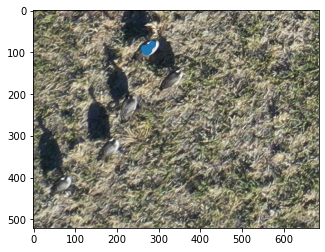

In [111]:
#Visualize one from "test" to see if the correct clusters seem to have been attached
testimg = "20211201_Atrisco_0465_07_01.png"
subset = test[test["filename_x"] == testimg]
onecluster = subset.loc[subset["cluster_id"] == 0]

# x_df = []
# y_df = []
# for coord in subset["centers"]:
#     x1 = coord[0]
#     x_df.append(x1)
#     y1 = coord[1]
#     y_df.append(y1)

fig, ax = plt.subplots()
img = cv2.imread(imgpath+"/20211201_Atrisco_0465_07_01.png")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
ax.imshow(img)
ax.scatter(onecluster["c_x"],onecluster["c_y"])

In [30]:
#Run DBSCAN (other option)
filegroups = df.groupby("filename")
filegroups.apply(lambda x: group_DBSCAN(x))

filename
20211201_Atrisco_0465_07_01.png                 [0, 1, 2, 3, 4, 4, 3, 2, 0, 1, 0, 1, -1, 4, 3,...
20220110_Bernardo_0001_01_03.png                [0, 1, 2, 3, -1, 4, 5, 6, 7, 1, 0, 2, 6, 7, 5,...
20220110_Bernardo_0230_05_08.png                [0, -1, -1, 1, 2, 3, 4, 5, 6, 4, 2, 1, 3, 0, 7...
20220110_Bernardo_0999_06_06.png                [0, 10, 1, 2, 3, -1, 4, 5, 12, 6, 7, 8, 9, 0, ...
20220111_Bernardo_0491_03_07.png                [0, 1, 2, 0, 1, 2, 1, 2, 0, 1, 2, -1, 1, 2, 0,...
20220111_LaJoya_1_0024_07_04.png                [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, ...
20220111_LaJoya_1_0024_07_07.png                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 9, 10, 7, 0...
20220111_LaJoya_2_0196_06_03.png                [0, 1, 2, 5, 3, 4, 4, 3, 5, 1, 2, 0, 2, 1, 0, ...
20220111_LaJoya_2_0196_07_05.png                                  [0, 0, 0, 0, -1, 0, 0, 0, 0, 0]
BDA_12c_20181113_1_00425_01_07.png              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...
BDA_12c_201

In [15]:
#REFINEMENT STEP: DUCK, GOOSE, CRANE

#Dictionary of category values
categories = {1: "Crane", 2: 'Goose', 3:'Duck'}

#Derive median bounding box
refined = test.groupby(['filename', 'cluster_id'])['x','y','w','h'].agg(pd.Series.median)
refined.reset_index("cluster_id")
#Make median bounding box into its own column in list form
refined['bbox']= refined.values.tolist()
refined


/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_8026/1048082381.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  refined = test.groupby(['filename', 'cluster_id'])['x','y','w','h'].agg(pd.Series.median)


x  \
filename                                     cluster_id               
20211201_Atrisco_0465_07_01.png              -1          175.000000   
                                              0          229.261566   
                                              1          292.656891   
                                              2          193.000000   
                                              3          139.633331   
...                                                             ...   
FWS_MaxwellLake13_20171215_3_01942_06_08.png  16         291.632751   
                                              17         247.284622   
                                              18         379.743103   
                                              19         427.873657   
                                              20         489.421051   

                                                                  y  \
filename                                     cluster_id               
20211201_Atrisco_0465_07_01.png              -1          210.466660   
                                              0           55.234375   
                                              1          127.250000   
                                              2          193.659042   
                                              3          296.623077   
...                                                             ...   
FWS_MaxwellLake13_20171215_3_01942_06_08.png  16         359.000000   
                                              17         454.567734   
                                              18         368.177094   
                                              19         392.156311   
                                              20         444.381348   

                                                                 w          h  \
filename                                     cluster_id                         
20211201_Atrisco_0465_07_01.png              -1          43.000000  44.000000   
                                              0          87.000000  76.000000   
                                              1          86.000000  78.000000   
                                              2          67.000000  79.000000   
                                              3          83.000000  74.815521   
...                                                            ...        ...   
FWS_MaxwellLake13_20171215_3_01942_06_08.png  16         40.000000  37.000000   
                                              17         36.753479  31.611969   
                                              18         35.000000  34.304520   
                                              19         35.557434  36.398438   
                                              20         47.780304  44.000000   

                                                                                                      bbox  
filename                                     cluster_id                                                     
20211201_Atrisco_0465_07_01.png              -1                    [175.0, 210.46665954589844, 43.0, 44.0]  
                                              0                [229.26156616210938, 55.234375, 87.0, 76.0]  
                                              1                    [292.6568908691406, 127.25, 86.0, 78.0]  
                                              2                    [193.0, 193.65904235839844, 67.0, 79.0]  
                                              3          [139.63333129882812, 296.6230773925781, 83.0, ...  
...                                                                                                    ...  
FWS_MaxwellLake13_20171215_3_01942_06_08.png  16                   [291.63275146484375, 359.0, 40.0, 37.0]  
                                              17         [247.2846221923828, 454.56773376464844, 36.753...  
                                              18         [379.743103027343

In [23]:
mode_class = test.groupby(["filename", "cluster_id"])['category_id'].agg(pd.Series.mode)


filename                                      cluster_id
20211201_Atrisco_0465_07_01.png               -1            2
                                               0            2
                                               1            2
                                               2            2
                                               3            2
                                                           ..
FWS_MaxwellLake13_20171215_3_01942_06_08.png   16           2
                                               17           2
                                               18           2
                                               19           2
                                               20           2
Name: category_id, Length: 264, dtype: object

In [22]:
#Derive plurality vote of class ID
mode_class = test.groupby("filename")["cluster_id",'category_id'].agg(pd.Series.mode)
#Join the refined results together
refined_id = pd.merge(refined, mode_class, left_on="cluster_id", right_on="cluster_id")
#Add back a column with category name to the refined results (optional)
refined_id['category'] = refined_id["category_id"].map(categories)
refined_id = refined_id.drop(columns=['x','y','w','h'])

/var/folders/21/q9_tvtjj53n6mfprd_174cz00000gn/T/ipykernel_8026/459777040.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mode_class = test.groupby("filename")["cluster_id",'category_id'].agg(pd.Series.mode)


TypeError: unhashable type: 'numpy.ndarray'

In [18]:
refined_id

NameError: name 'refined_id' is not defined

In [117]:
#Checking that refined bounding boxes appear as expected
testimg = "20211201_Atrisco_0465_07_01.png"
subset = refined_id[refined_id["filename"] == testimg]
#onecluster = subset.loc[subset["cluster_id"] == 0]

bboxes = subset["bbox"]

def get_bb(bboxes, img):  
    boxes = bboxes.copy()
    
    return np.squeeze(boxes)

def img_show(img, ax = None, figsize=(7,11)):
  if ax is None: fig, ax = plt.subplots(figsize=figsize)
  ax.xaxis.tick_top()
  ax.imshow(img)  
  return ax

def draw_box(img, ax, bb):
  patch = ax.add_patch(patches.Rectangle((bb[0],bb[1]), bb[2], bb[3], fill=False, edgecolor='red', lw=2))
  
def plot_sample(img,bboxes, ax=None, figsize=(7,11)):
  bb = get_bb(bboxes, img)
  ax = img_show(img, ax=ax)
  for i in range(len(bboxes)):
    draw_box(img,ax,bb[i])

plot_sample(img,bboxes)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#REFINEMENT STEP: DGC, SEAGULL

#Dictionary of category values
categories = {1: "Goose", 2: 'Seagull', 3:'Duck', 4:'Crane'}

#Derive median bounding box 
refined = filegroups.groupby("filename")['x','y','w','h'].agg(pd.Series.median)
refined.reset_index("cluster_id")
#Make median bounding box into its own column in list form
refined['bbox']= refined.values.tolist()
#Derive plurality vote of class ID
mode_class = filegroups.groupby("cluster_id")["filename",'category_id'].agg(pd.Series.mode)
#Join the refined results together
refined_id = pd.merge(refined, mode_class, left_on="cluster_id", right_on="cluster_id")
#Add back a column with category name to the refined results (optional)
refined_id['category'] = refined_id["category_id"].map(categories)
refined_id = refined_id.drop(columns=['x','y','w','h'])

In [ ]:
#EXPORT OF REFINED RESULTS FOR USE AS TRAIN/VAL/TEST (not split yet; determine split after getting new data stats)

#add individual annotation ID column
export = refined_id.reset_index
#drop "cluster ID" column
export.drop(columns="cluster_id")
#save to csv
exportconsensus = datetime.now().strftime('%Y%m%d_consensuslabels.csv')
export.to_csv(exportconsensus)

In [ ]:
#EXPORT OF ANALYSIS DATAFRAME
df_analysis = pd.merge(df, refined_id, left_on="cluster_id", right_on="cluster_id")
df_analysis = df_analysis.drop(columns=['centers','area','x','y','w','h', 'filename_y'])
df_analysis = df_analysis.rename(columns={'filename_x':'filename', 'bbox_x': 'bbox_orig', 'category_id_x': 'cat_id_orig', "category_x": "cat_orig", 'bbox_y': 'bbox_refined', 'category_id_y': 'cat_id_refined', "category_y": "cat_refined"})
exportanalysis = datetime.now().strftime('%Y%m%d_analysislabels.csv')
df_analysis.to_csv(exportanalysis)